In [5]:
# seeing if standard scaling will improve the model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt


In [6]:
# creating a function to apply standard scaling to each image
def standard_scale_batch(batch):
    scaler = StandardScaler()
    # Reshape to (number of images, height*width*channels) for scaling
    original_shape = batch.shape
    batch = batch.reshape((batch.shape[0], -1))
    batch = scaler.fit_transform(batch)
    # Reshape back to original image dimensions
    batch = batch.reshape(original_shape)
    return batch


In [7]:
train_dir = '../Resources/cropped/train'
val_dir = '../Resources/cropped/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 12000 images belonging to 120 classes.
Found 8580 images belonging to 120 classes.


In [8]:
def generate_batches(generator):
    while True:
        batch_x, batch_y = next(generator)
        batch_x = standard_scale_batch(batch_x)
        yield batch_x, batch_y


In [9]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


/Users/armandocota/anaconda3/envs/dev/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 120)            │        61,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,514,168 (13.41 MB)

 Trainable params: 3,514,168 (13.41 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# training the model with scaled images
history = model.fit(
    generate_batches(train_generator),
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=generate_batches(validation_generator),
    validation_steps=validation_generator.samples // validation_generator.batch_size
)
# evaluating the model
score = model.evaluate(generate_batches(validation_generator), steps=validation_generator.samples // validation_generator.batch_size)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 276s 732ms/step - accuracy: 0.0095 - loss: 4.8045 - val_accuracy: 0.0133 - val_loss: 4.7872
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 277s 739ms/step - accuracy: 0.0073 - loss: 4.7880 - val_accuracy: 0.0129 - val_loss: 4.7873
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 278s 743ms/step - accuracy: 0.0085 - loss: 4.7880 - val_accuracy: 0.0081 - val_loss: 4.7876
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 282s 753ms/step - accuracy: 0.0077 - loss: 4.7879 - val_accuracy: 0.0061 - val_loss: 4.7876
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 281s 748ms/step - accuracy: 0.0084 - loss: 4.7879 - val_accuracy: 0.0120 - val_loss: 4.7876
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 277s 739ms/step - accuracy: 0.0081 - loss: 4.7880 - val_accuracy: 0.0066 - val_loss: 4.7876
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 268s 715ms/step - accuracy: 0.0089 - loss: 4.7879 - val_accuracy: 0.0058 - val_loss: 4.7875
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 260s 694ms/step - accuracy: 0.0071 -

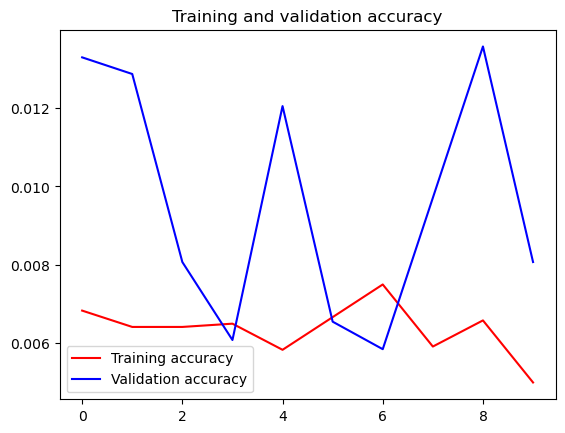

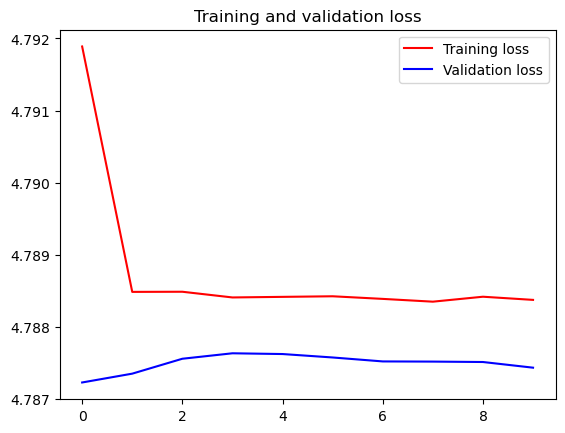

In [13]:
# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
image_path1 = '../Outputs/train_validation_accuracy.jpg'
plt.savefig(image_path1)

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
image_path2 = '../Outputs/traind_validation_loss.jpg'
plt.savefig(image_path2)
plt.show()



In [12]:
# save the model
model.save('../Outputs/image_classification_model.h5')